<a href="https://colab.research.google.com/github/NightWalker888/ai_painting_journey/blob/main/lesson21/ControlNet%E7%BA%BF%E7%A8%BF%E4%B8%8A%E8%89%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 检查GPU环境。如提示无GPU，需要点击「修改」-「笔记本设置」-「GPU-T4」，然后点击右上角的连接按键。
!nvidia-smi

Sat Aug 19 08:51:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 安装基础工具包

In [2]:
!pip install -qq diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -qq opencv-contrib-python
!pip install -qq controlnet_aux

In [4]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image, ImageOps
import numpy as np
from transformers import pipeline


from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

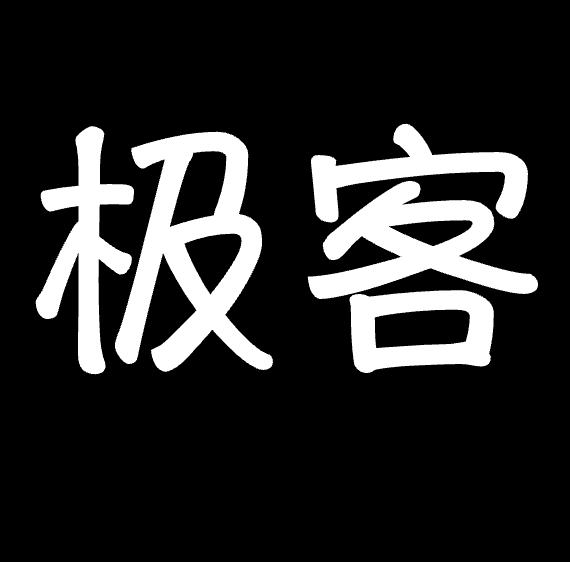

In [5]:
image = load_image(
    "https://ice.frostsky.com/2023/08/19/f9a6a52b210fb8dbc0fe347efbb22d9f.png"
)

# 将图像黑白颜色反转，得到的效果会更好
inverted_image = ImageOps.invert(image)
inverted_image

In [6]:
image = inverted_image
prompt = "High detail,(detailed light:0.8),rainwater,Ambient light,3d rendering,realistic,8k,cinema light,(Osmanthus fragrans:1.4),Osmanthus fragrans,Water drop,(rain:1.2),(Fuzzy background:1.2), Above water, Plant in soil, pond"

depth_estimator = pipeline('depth-estimation')
image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = Image.fromarray(image)

control_image.save("control.png")

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
# 使用ControlNet1.1的depth模型
checkpoint = "lllyasviel/control_v11f1p_sd15_depth"
controlnet = ControlNetModel.from_pretrained(checkpoint, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [8]:
generator = torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=30, generator=generator, image=control_image).images[0]

image.save('image_out.png')

  0%|          | 0/30 [00:00<?, ?it/s]

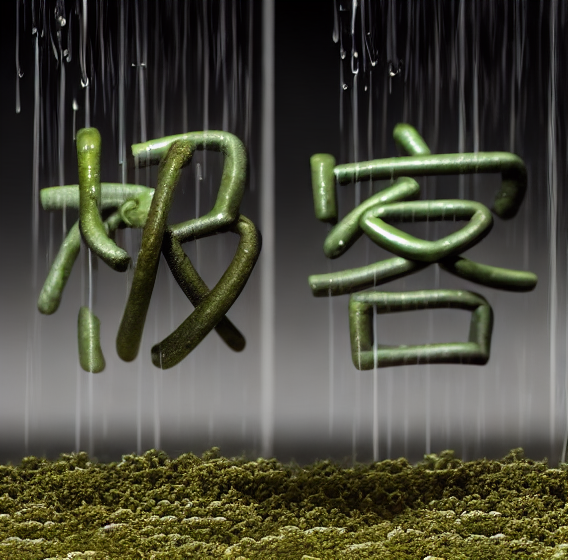

In [9]:
image

## 测试下不颜色反转的效果

In [10]:
image = load_image(
    "https://ice.frostsky.com/2023/08/19/f9a6a52b210fb8dbc0fe347efbb22d9f.png"
)


In [11]:
prompt = "High detail,(detailed light:0.8),rainwater,Ambient light,3d rendering,realistic,8k,cinema light,(Osmanthus fragrans:1.4),Osmanthus fragrans,Water drop,(rain:1.2),(Fuzzy background:1.2), Above water, Plant in soil, pond"

depth_estimator = pipeline('depth-estimation')
image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = Image.fromarray(image)

control_image.save("control_noinvert.png")

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


  0%|          | 0/30 [00:00<?, ?it/s]

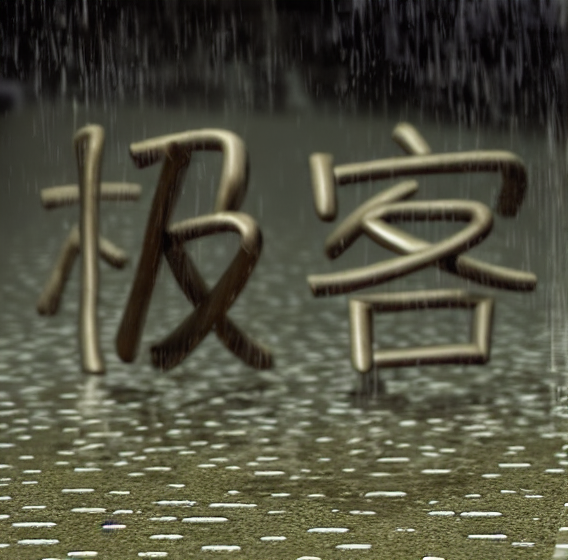

In [12]:
generator = torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=30, generator=generator, image=control_image).images[0]
image